# Window Size
## The main purpose of this notebook is to experiment with different window sizes on finding anomalies

In [75]:
# Import required libraries
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Input, Dropout
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Model, load_model
import seaborn as sns
import datetime

import os.path

from importlib import reload

from utils import *
from autoencoder import AutoEncoder

In [173]:
%reload_ext autoreload
# %aimport utils
# %aimport autoencoder
%autoreload 2

In [56]:
# Import preprocessed data
file_path = '/Users/jamesmeyer/University of Bath/Patient Simulator FYP - General/datasets/'
DIAGRAM_FILE_PATH = '/Users/jamesmeyer/University of Bath/Patient Simulator FYP - General/diagrams/'

## WINDOW SIZE = 20

In [57]:
file_version = 'ws20num2derFalse'
sensors = ['left_angle', 'right_angle'] #'back_angle', 
file_name = f'{file_version}-control.npy'
path = file_path + file_name
trainX = np.load(path)
print(f'Number of control training samples: {trainX.shape}')

Number of control training samples: (12022, 20, 2)


In [85]:
# Load just the patient data
file_patient = f'{file_version}-patient-shaved.npy'
path = file_path + file_patient
patientX = np.load(path)
print(f'Number of patient testing samples: {patientX.shape}')

Number of patient testing samples: (38167, 20, 2)


In [58]:
# Retrieve data and place with pd dataframe
patient_file_path = '/Users/jamesmeyer/University of Bath/Patient Simulator FYP - General/datasets/patient/patient_data.csv'
dataframe = pd.read_csv(patient_file_path, parse_dates=['datetime'])
df = dataframe.loc[:,sensors]
df.loc[:,'Date'] = pd.to_datetime(dataframe.loc[:,'datetime'])

# Split test and train data
train, test = df.loc[df['Date'] <= '2011-12-01 11:38:00'], df.loc[df['Date'] > '2011-12-01 11:38:00']
train

left_angle  right_angle                    Date
0        0.572584     0.215395 2011-12-01 11:04:05.000
1        0.568733     0.200416 2011-12-01 11:04:05.050
2        0.564883     0.200416 2011-12-01 11:04:05.100
3        0.557181     0.201110 2011-12-01 11:04:05.150
4        0.541779     0.200416 2011-12-01 11:04:05.200
...           ...          ...                     ...
38182    0.276088     0.527046 2011-12-01 11:35:54.100
38183    0.276088     0.525659 2011-12-01 11:35:54.150
38184    0.276088     0.524272 2011-12-01 11:35:54.200
38185    0.276088     0.524272 2011-12-01 11:35:54.250
38186    0.276088     0.524272 2011-12-01 11:35:54.300

[38187 rows x 3 columns]

In [59]:
compress = 0.4
units_one = int(trainX.shape[1] * trainX.shape[2] * compress)
units_two = int(units_one * 0.5)
print(f"1st layer units: {units_one}, 2nd layer units: {units_two}")

1st layer units: 16, 2nd layer units: 8


In [60]:
twen_time_code = '16300_0421'
twen_model_file = f'{twen_time_code}-model.h5'
twen_model_file

'16300_0421-model.h5'

Double layer model built
Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_52 (LSTM)               (None, 20, 16)            1216      
_________________________________________________________________
dropout_26 (Dropout)         (None, 20, 16)            0         
_________________________________________________________________
lstm_53 (LSTM)               (None, 8)                 800       
_________________________________________________________________
repeat_vector_13 (RepeatVect (None, 20, 8)             0         
_________________________________________________________________
lstm_54 (LSTM)               (None, 20, 8)             544       
_________________________________________________________________
lstm_55 (LSTM)               (None, 20, 16)            1600      
_________________________________________________________________
dropout_27 (Dropout)        

<module 'matplotlib.pyplot' from '/Users/jamesmeyer/.pyenv/versions/fyp-env/lib/python3.9/site-packages/matplotlib/pyplot.py'>

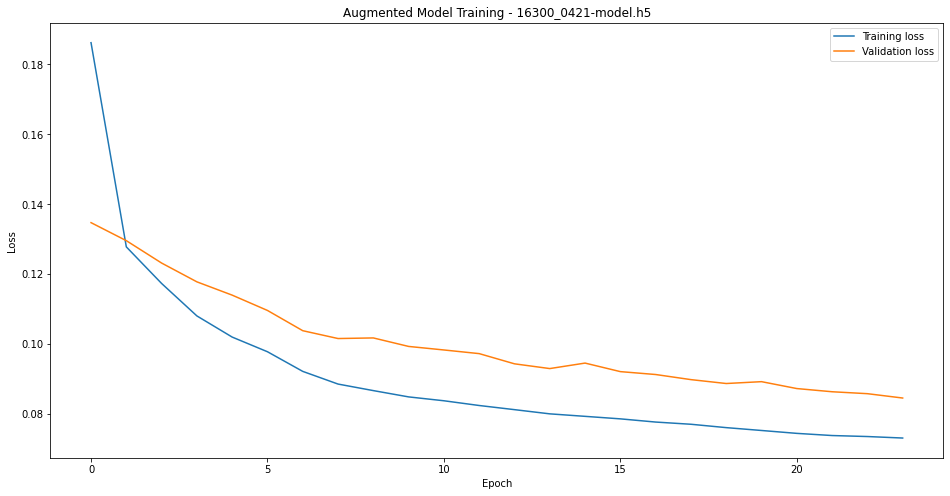

In [77]:
# Fit the model
callback = EarlyStopping(monitor='loss', patience=2, min_delta=1e-3)
WZ_twenty = AutoEncoder(units_one, units_two, trainX, twen_model_file, callback)

# Show the history of loss
history_plot_and_save(WZ_twenty.history, twen_model_file, DIAGRAM_FILE_PATH)


In [86]:
patientPredict = WZ_twenty.model.predict(patientX)

In [87]:
no_feats = trainX.shape[2]
seq_size = trainX.shape[1]
example = 10

<module 'matplotlib.pyplot' from '/Users/jamesmeyer/.pyenv/versions/fyp-env/lib/python3.9/site-packages/matplotlib/pyplot.py'>

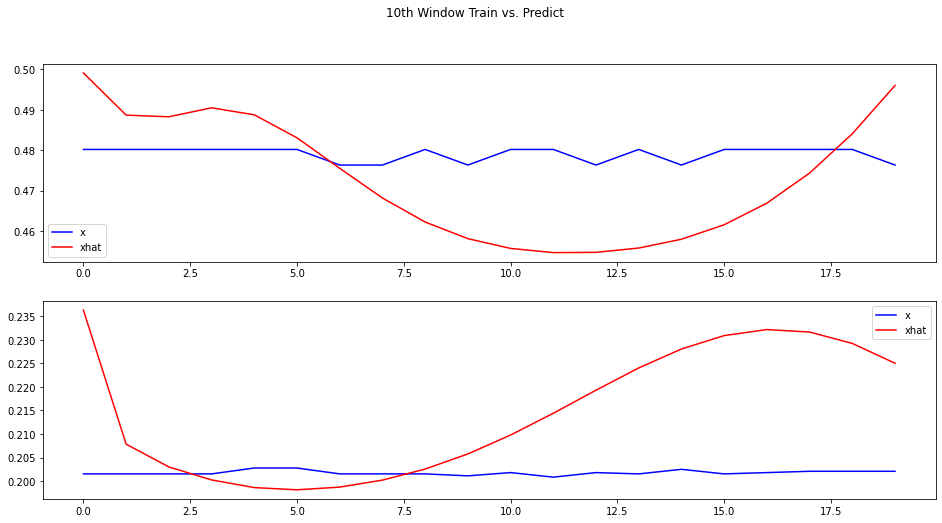

In [88]:
example_plot(example, no_feats, seq_size, patientX, patientPredict)

In [89]:
area_error = error_computation(patientX, patientPredict, 'Area')
area_error.shape

(38167, 2)

Saved as: /Users/jamesmeyer/University of Bath/Patient Simulator FYP - General/diagrams/error-hist-Area-16300_0421-model.h5-1.png


<module 'matplotlib.pyplot' from '/Users/jamesmeyer/.pyenv/versions/fyp-env/lib/python3.9/site-packages/matplotlib/pyplot.py'>

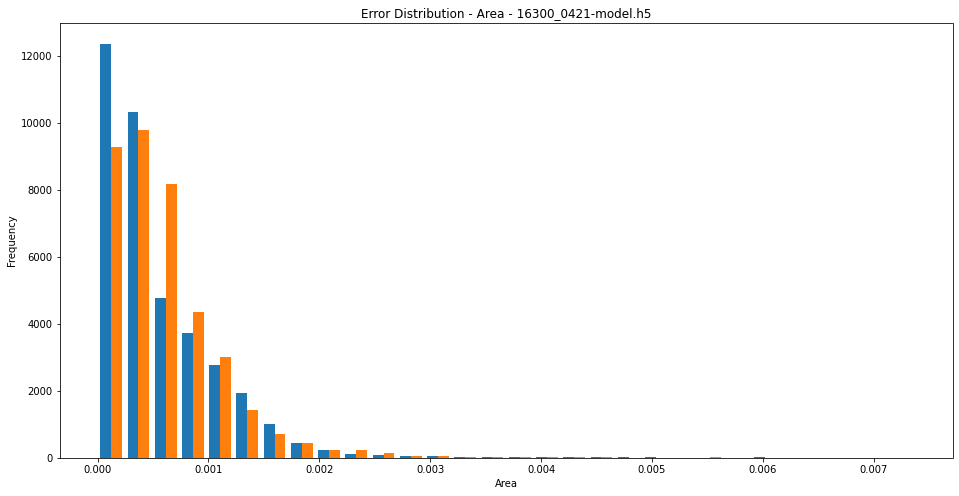

In [172]:
error_hist_and_save(area_error, 'Area', twen_model_file, DIAGRAM_FILE_PATH)

In [91]:
pct = 0.8
thresh = fixed_thresh(pct, area_error, len(train[seq_size:]))
thresh

array([0.00104509, 0.00104509, 0.00104509, ..., 0.00104509, 0.00104509,
       0.00104509])

In [92]:
anomaly_frame = anomaly_df(train, seq_size, area_error, thresh)
anomaly_frame.head()

left_angle  right_angle                    Date     error    thresh  \
20    0.480169     0.201803 2011-12-01 11:04:06.000  0.000262  0.001045   
21    0.480169     0.200832 2011-12-01 11:04:06.050  0.000263  0.001045   
22    0.476319     0.201803 2011-12-01 11:04:06.100  0.000268  0.001045   
23    0.480169     0.201526 2011-12-01 11:04:06.150  0.000275  0.001045   
24    0.476319     0.202497 2011-12-01 11:04:06.200  0.000281  0.001045   

    anomaly  
20    False  
21    False  
22    False  
23    False  
24    False

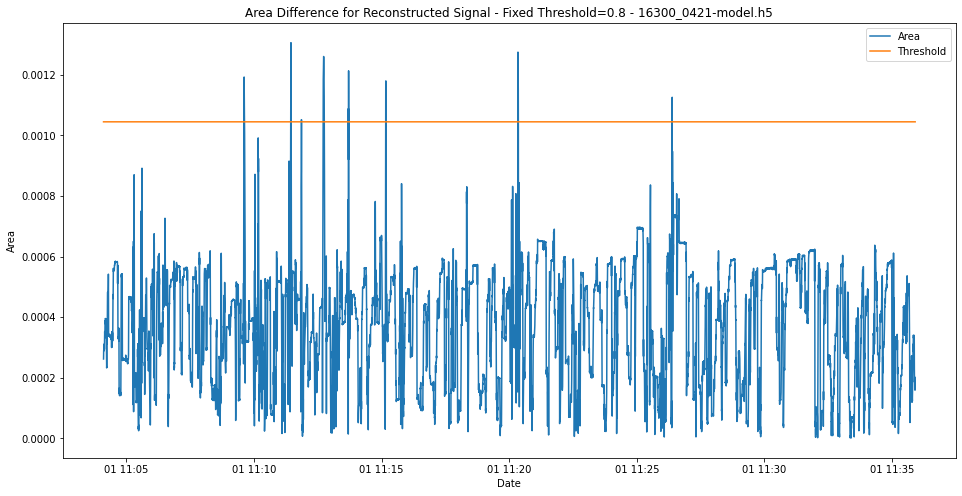

In [93]:
anomalies, _ = error_vs_thresh_plot_and_save(anomaly_frame, pct, 'Area', twen_model_file, DIAGRAM_FILE_PATH)

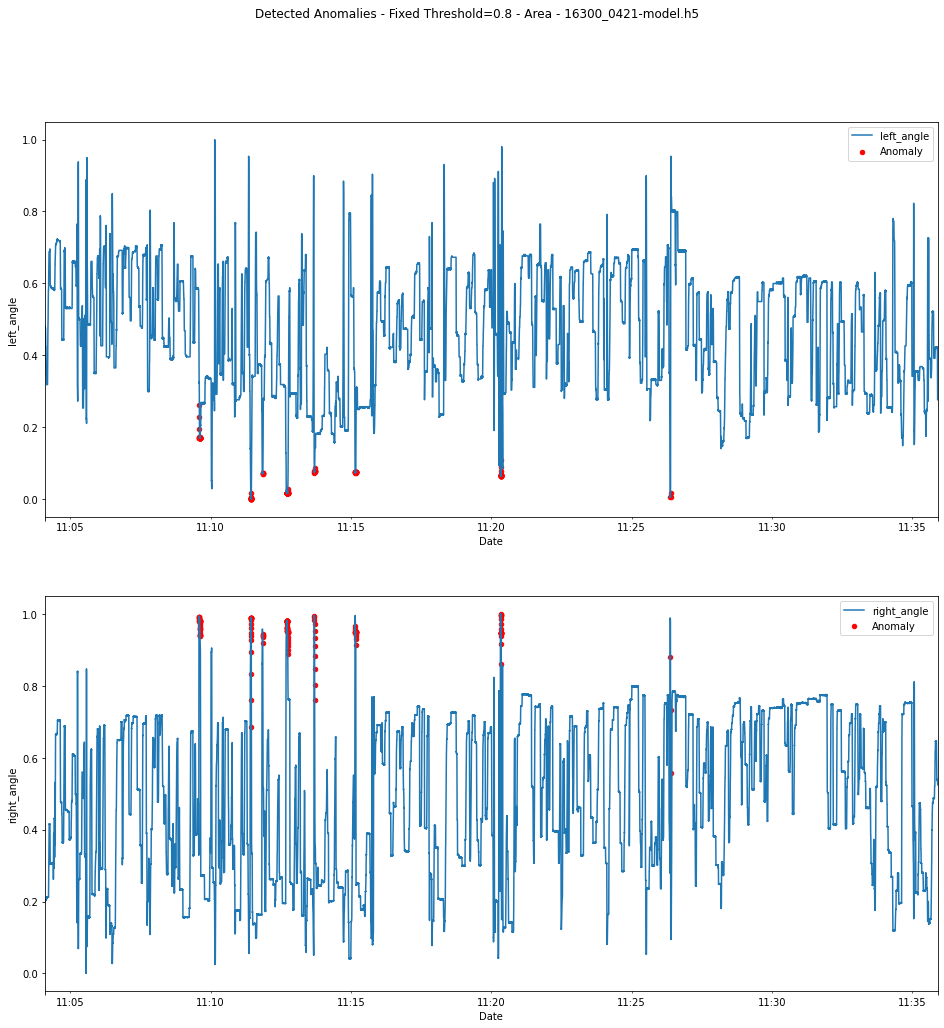

In [94]:
detect_anom_plot_and_save(no_feats, sensors, anomaly_frame, anomalies, pct, 'Area', twen_model_file, DIAGRAM_FILE_PATH)

## WINDOW SIZE = 40

In [95]:
file_version = 'ws40num2derFalse'
sensors = ['left_angle', 'right_angle'] #'back_angle', 
file_name = f'{file_version}-control.npy'
path = file_path + file_name
trainX = np.load(path)
print(f'Number of control training samples: {trainX.shape}')

Number of control training samples: (9825, 40, 2)


In [96]:
# Load just the patient data
file_patient = f'{file_version}-patient-shaved.npy'
path = file_path + file_patient
patientX = np.load(path)
print(f'Number of patient testing samples: {patientX.shape}')

Number of patient testing samples: (38147, 40, 2)


In [97]:
compress = 0.4
units_one = int(trainX.shape[1] * trainX.shape[2] * compress)
units_two = int(units_one * 0.5)
print(f"1st layer units: {units_one}, 2nd layer units: {units_two}")

1st layer units: 32, 2nd layer units: 16


In [98]:
fort_time_code = '171500_0421'
fort_model_file = f'{fort_time_code}-model.h5'
fort_model_file

'171500_0421-model.h5'

Checking for 171500_0421-model.h5

Double layer model built
Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_64 (LSTM)               (None, 40, 32)            4480      
_________________________________________________________________
dropout_32 (Dropout)         (None, 40, 32)            0         
_________________________________________________________________
lstm_65 (LSTM)               (None, 16)                3136      
_________________________________________________________________
repeat_vector_16 (RepeatVect (None, 40, 16)            0         
_________________________________________________________________
lstm_66 (LSTM)               (None, 40, 16)            2112      
_________________________________________________________________
lstm_67 (LSTM)               (None, 40, 32)            6272      
___________________________________________________________

<module 'matplotlib.pyplot' from '/Users/jamesmeyer/.pyenv/versions/fyp-env/lib/python3.9/site-packages/matplotlib/pyplot.py'>

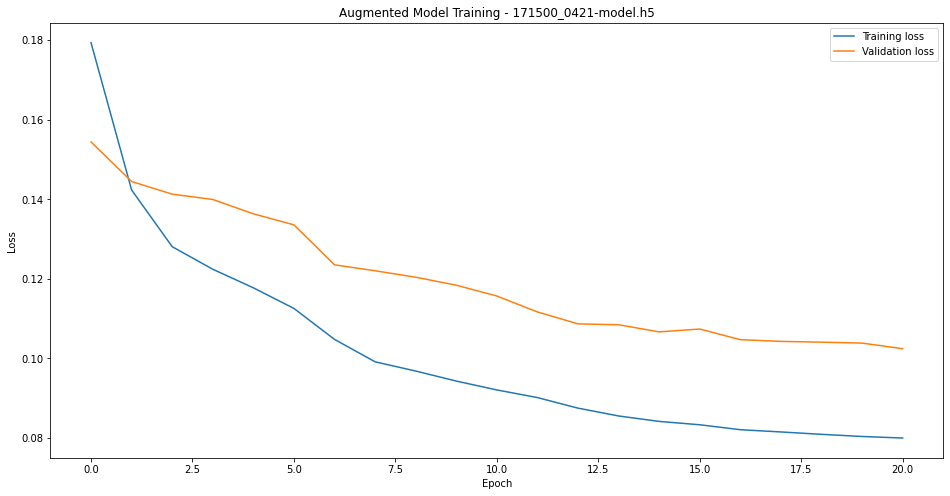

In [99]:
# Fit the model
callback = EarlyStopping(monitor='loss', patience=2, min_delta=1e-3)
WZ_forty = AutoEncoder(units_one, units_two, trainX, fort_model_file, callback)

# Show the history of loss
history_plot_and_save(WZ_forty.history, fort_model_file, DIAGRAM_FILE_PATH)


In [100]:
patientPredict = WZ_forty.model.predict(patientX)

In [101]:
no_feats = trainX.shape[2]
seq_size = trainX.shape[1]
example = 10

<module 'matplotlib.pyplot' from '/Users/jamesmeyer/.pyenv/versions/fyp-env/lib/python3.9/site-packages/matplotlib/pyplot.py'>

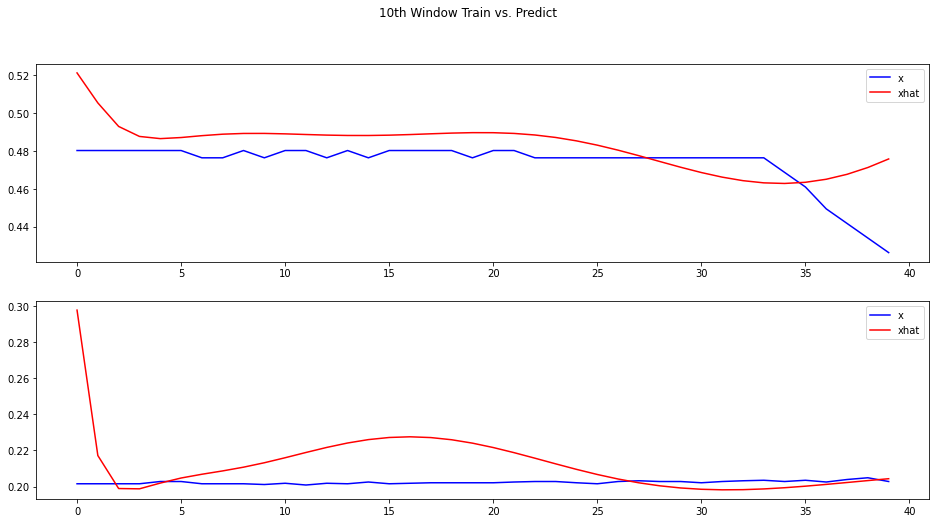

In [102]:
example_plot(example, no_feats, seq_size, patientX, patientPredict)

In [103]:
area_error = error_computation(patientX, patientPredict, 'Area')
area_error.shape

(38147, 2)

<module 'matplotlib.pyplot' from '/Users/jamesmeyer/.pyenv/versions/fyp-env/lib/python3.9/site-packages/matplotlib/pyplot.py'>

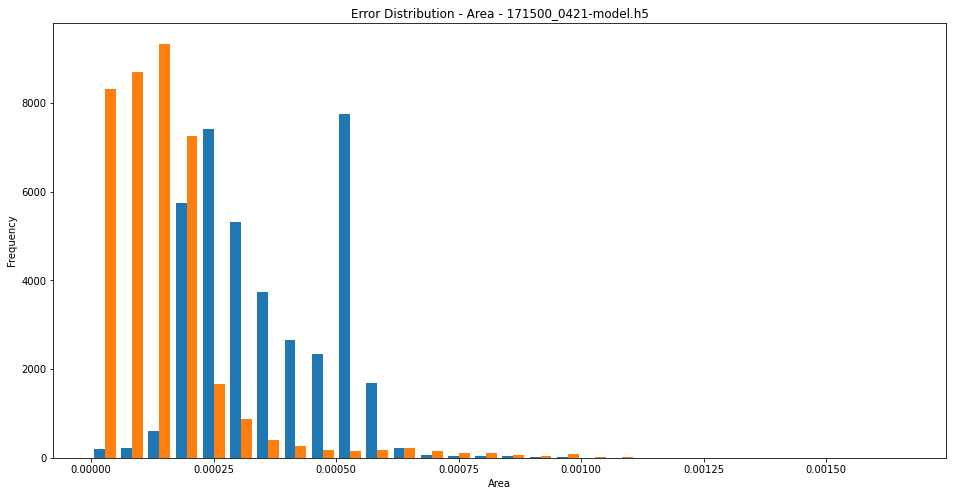

In [104]:
error_hist_and_save(area_error, 'Area', fort_model_file, DIAGRAM_FILE_PATH)

In [105]:
pct = 0.8
thresh = fixed_thresh(pct, area_error, len(train[seq_size:]))
thresh

array([0.00133377, 0.00133377, 0.00133377, ..., 0.00133377, 0.00133377,
       0.00133377])

In [106]:
anomaly_frame = anomaly_df(train, seq_size, area_error, thresh)
anomaly_frame.head()

left_angle  right_angle                    Date     error    thresh  \
40    0.476319     0.202080 2011-12-01 11:04:07.000  0.000234  0.001334   
41    0.476319     0.202774 2011-12-01 11:04:07.050  0.000230  0.001334   
42    0.476319     0.203190 2011-12-01 11:04:07.100  0.000224  0.001334   
43    0.476319     0.203467 2011-12-01 11:04:07.150  0.000220  0.001334   
44    0.468618     0.202774 2011-12-01 11:04:07.200  0.000217  0.001334   

    anomaly  
40    False  
41    False  
42    False  
43    False  
44    False

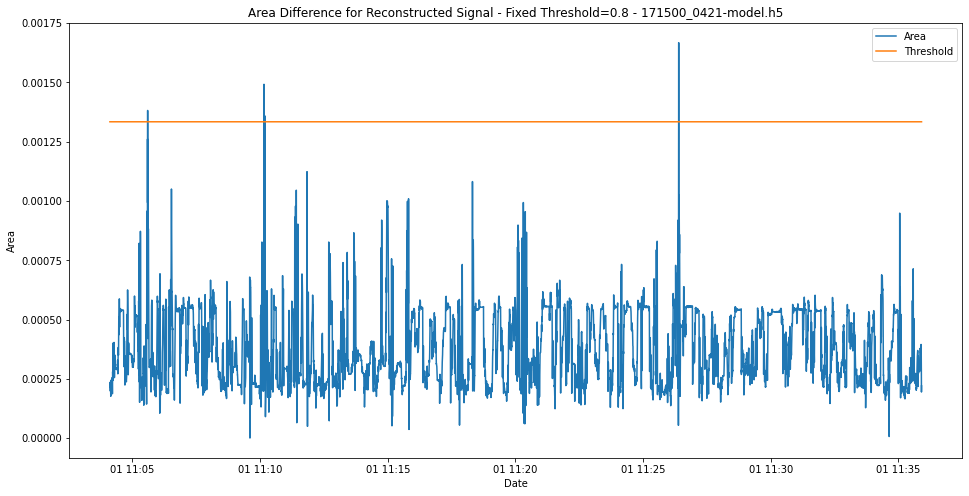

In [107]:
anomalies, _ = error_vs_thresh_plot_and_save(anomaly_frame, pct, 'Area', fort_model_file, DIAGRAM_FILE_PATH)

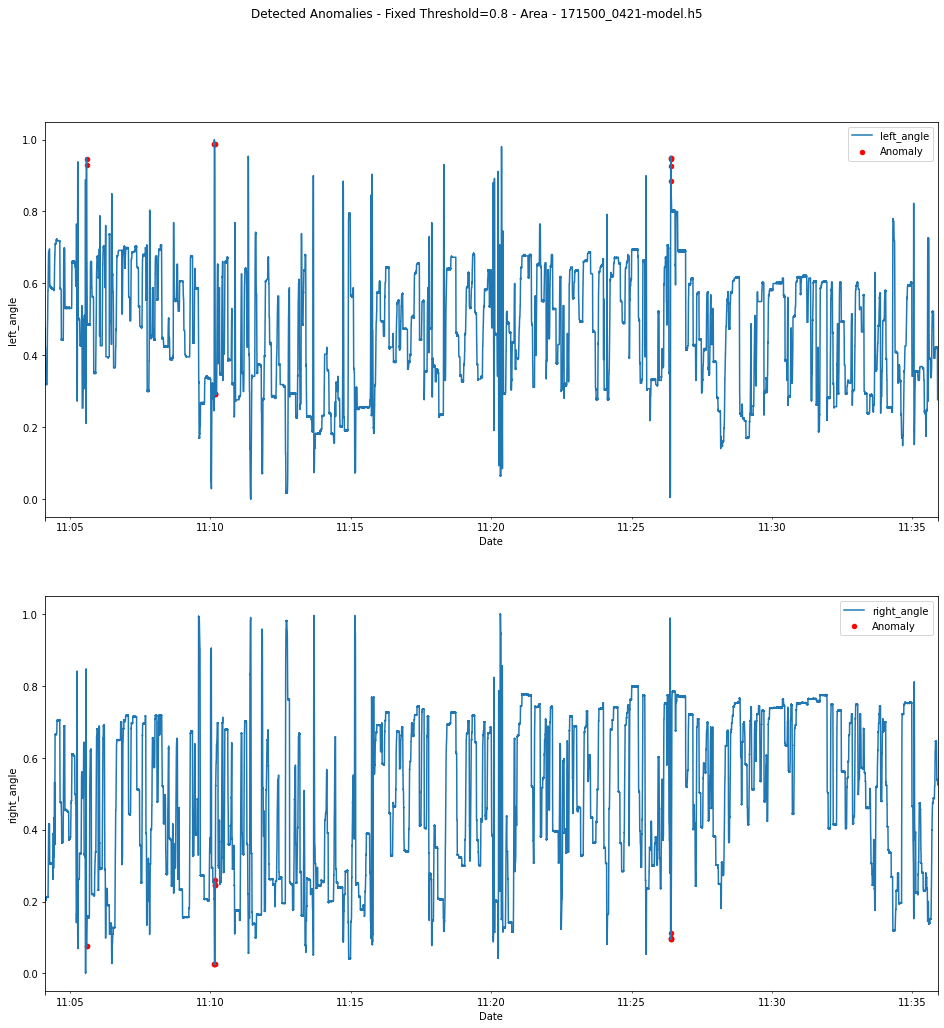

In [108]:
detect_anom_plot_and_save(no_feats, sensors, anomaly_frame, anomalies, pct, 'Area', fort_model_file, DIAGRAM_FILE_PATH)

## WINDOW SIZE = 60

In [109]:
file_version = 'ws60num2derFalse'
sensors = ['left_angle', 'right_angle'] #'back_angle', 
file_name = f'{file_version}-control.npy'
path = file_path + file_name
trainX = np.load(path)
print(f'Number of control training samples: {trainX.shape}')

Number of control training samples: (7649, 60, 2)


In [110]:
# Load just the patient data
file_patient = f'{file_version}-patient-shaved.npy'
path = file_path + file_patient
patientX = np.load(path)
print(f'Number of patient testing samples: {patientX.shape}')

Number of patient testing samples: (38127, 60, 2)


In [111]:
compress = 0.4
units_one = int(trainX.shape[1] * trainX.shape[2] * compress)
units_two = int(units_one * 0.5)
print(f"1st layer units: {units_one}, 2nd layer units: {units_two}")

1st layer units: 48, 2nd layer units: 24


In [112]:
sixt_time_code = '173000_0421'
sixt_model_file = f'{sixt_time_code}-model.h5'
sixt_model_file

'173000_0421-model.h5'

Checking for 173000_0421-model.h5

Double layer model built
Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_68 (LSTM)               (None, 60, 48)            9792      
_________________________________________________________________
dropout_34 (Dropout)         (None, 60, 48)            0         
_________________________________________________________________
lstm_69 (LSTM)               (None, 24)                7008      
_________________________________________________________________
repeat_vector_17 (RepeatVect (None, 60, 24)            0         
_________________________________________________________________
lstm_70 (LSTM)               (None, 60, 24)            4704      
_________________________________________________________________
lstm_71 (LSTM)               (None, 60, 48)            14016     
___________________________________________________________

<module 'matplotlib.pyplot' from '/Users/jamesmeyer/.pyenv/versions/fyp-env/lib/python3.9/site-packages/matplotlib/pyplot.py'>

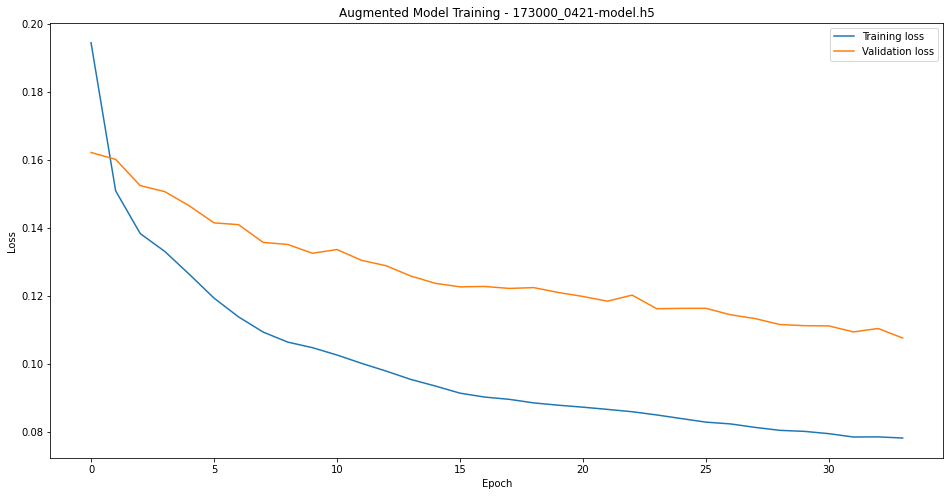

In [113]:
# Fit the model
callback = EarlyStopping(monitor='loss', patience=2, min_delta=1e-3)
WZ_sixt = AutoEncoder(units_one, units_two, trainX, sixt_model_file, callback)

# Show the history of loss
history_plot_and_save(WZ_sixt.history, sixt_model_file, DIAGRAM_FILE_PATH)

In [114]:
patientPredict = WZ_sixt.model.predict(patientX)

In [115]:
no_feats = trainX.shape[2]
seq_size = trainX.shape[1]
example = 10

<module 'matplotlib.pyplot' from '/Users/jamesmeyer/.pyenv/versions/fyp-env/lib/python3.9/site-packages/matplotlib/pyplot.py'>

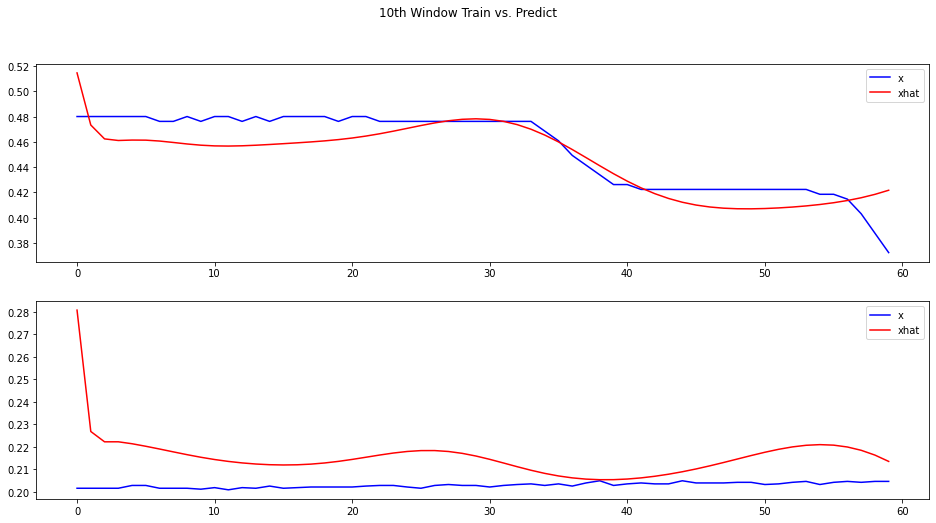

In [116]:
example_plot(example, no_feats, seq_size, patientX, patientPredict)

In [117]:
area_error = error_computation(patientX, patientPredict, 'Area')
area_error.shape

(38127, 2)

<module 'matplotlib.pyplot' from '/Users/jamesmeyer/.pyenv/versions/fyp-env/lib/python3.9/site-packages/matplotlib/pyplot.py'>

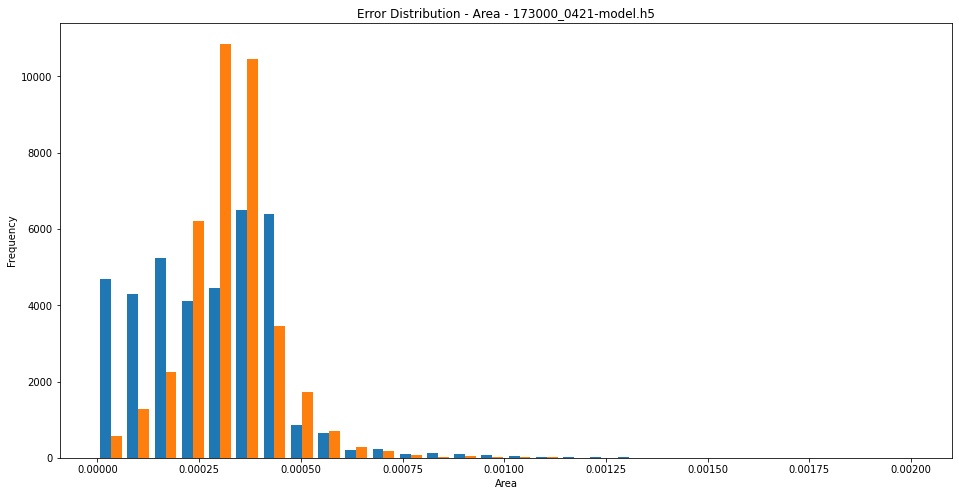

In [118]:
error_hist_and_save(area_error, 'Area', sixt_model_file, DIAGRAM_FILE_PATH)

In [ ]:
pct = 0.8
thresh = fixed_thresh(pct, area_error, len(train[seq_size:]))
thresh

In [ ]:
anomaly_frame = anomaly_df(train, seq_size, area_error, thresh)
anomaly_frame.head()

In [ ]:
anomalies, _ = error_vs_thresh_plot_and_save(anomaly_frame, pct, 'Area', sixt_model_file, DIAGRAM_FILE_PATH)

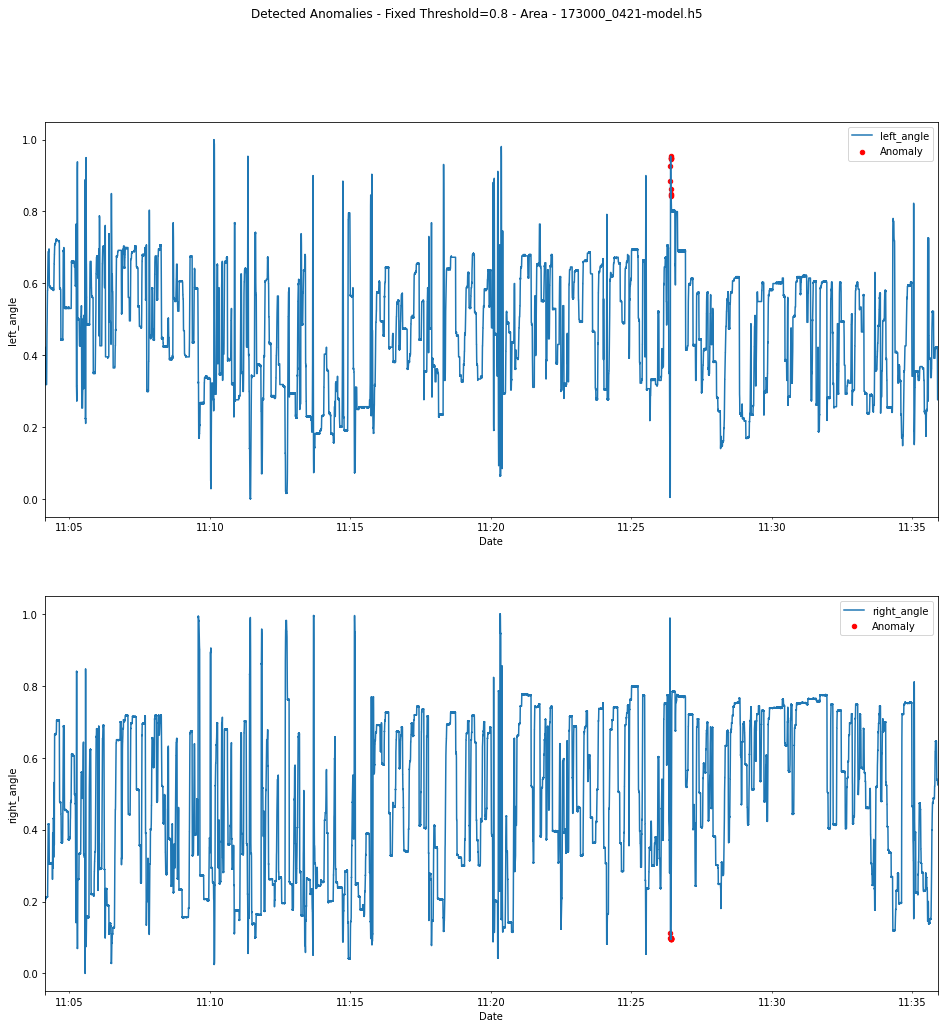

In [122]:
detect_anom_plot_and_save(no_feats, sensors, anomaly_frame, anomalies, pct, 'Area', sixt_model_file, DIAGRAM_FILE_PATH)

## WINDOW SIZE = 80

In [123]:
file_version = 'ws80num2derFalse'
sensors = ['left_angle', 'right_angle'] #'back_angle', 
file_name = f'{file_version}-control.npy'
path = file_path + file_name
trainX = np.load(path)
print(f'Number of control training samples: {trainX.shape}')

Number of control training samples: (5626, 80, 2)


In [124]:
# Load just the patient data
file_patient = f'{file_version}-patient-shaved.npy'
path = file_path + file_patient
patientX = np.load(path)
print(f'Number of patient testing samples: {patientX.shape}')

Number of patient testing samples: (38107, 80, 2)


In [125]:
compress = 0.4
units_one = int(trainX.shape[1] * trainX.shape[2] * compress)
units_two = int(units_one * 0.5)
print(f"1st layer units: {units_one}, 2nd layer units: {units_two}")

1st layer units: 64, 2nd layer units: 32


In [126]:
eight_time_code = '180000_0421'
eight_model_file = f'{eight_time_code}-model.h5'
eight_model_file

'180000_0421-model.h5'

Checking for 180000_0421-model.h5

Double layer model built
Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_72 (LSTM)               (None, 80, 64)            17152     
_________________________________________________________________
dropout_36 (Dropout)         (None, 80, 64)            0         
_________________________________________________________________
lstm_73 (LSTM)               (None, 32)                12416     
_________________________________________________________________
repeat_vector_18 (RepeatVect (None, 80, 32)            0         
_________________________________________________________________
lstm_74 (LSTM)               (None, 80, 32)            8320      
_________________________________________________________________
lstm_75 (LSTM)               (None, 80, 64)            24832     
___________________________________________________________

<module 'matplotlib.pyplot' from '/Users/jamesmeyer/.pyenv/versions/fyp-env/lib/python3.9/site-packages/matplotlib/pyplot.py'>

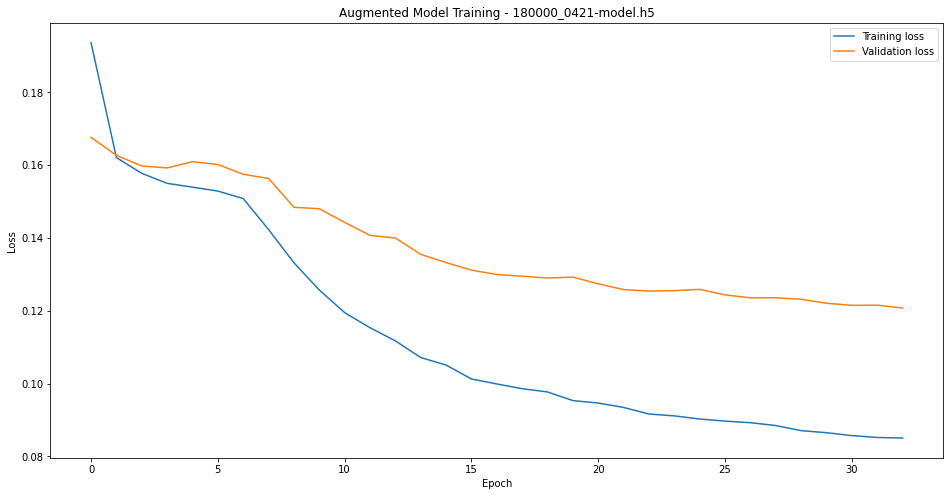

In [127]:
# Fit the model
callback = EarlyStopping(monitor='loss', patience=2, min_delta=1e-3)
WZ_eight = AutoEncoder(units_one, units_two, trainX, eight_model_file, callback)

# Show the history of loss
history_plot_and_save(WZ_eight.history, eight_model_file, DIAGRAM_FILE_PATH)

In [128]:
patientPredict = WZ_eight.model.predict(patientX)

In [129]:
no_feats = trainX.shape[2]
seq_size = trainX.shape[1]
example = 10

<module 'matplotlib.pyplot' from '/Users/jamesmeyer/.pyenv/versions/fyp-env/lib/python3.9/site-packages/matplotlib/pyplot.py'>

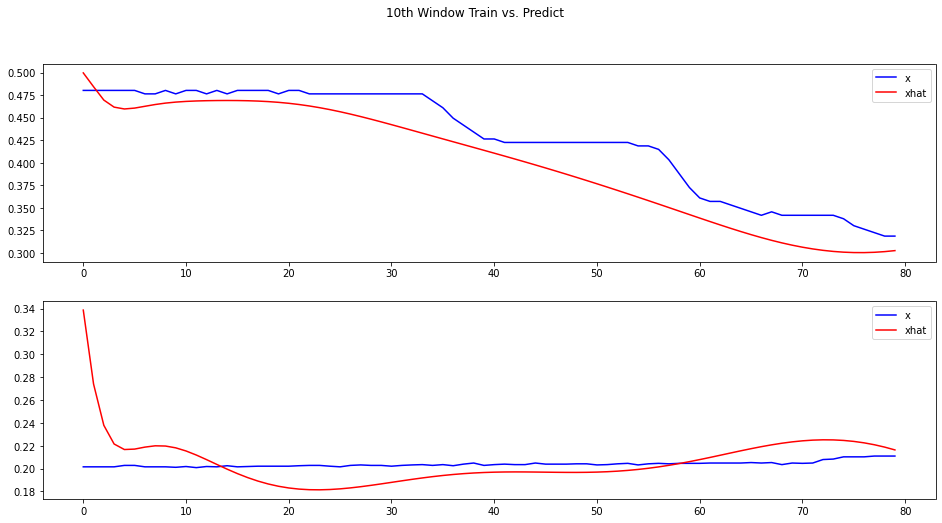

In [130]:
example_plot(example, no_feats, seq_size, patientX, patientPredict)

In [131]:
area_error = error_computation(patientX, patientPredict, 'Area')
area_error.shape

(38107, 2)

<module 'matplotlib.pyplot' from '/Users/jamesmeyer/.pyenv/versions/fyp-env/lib/python3.9/site-packages/matplotlib/pyplot.py'>

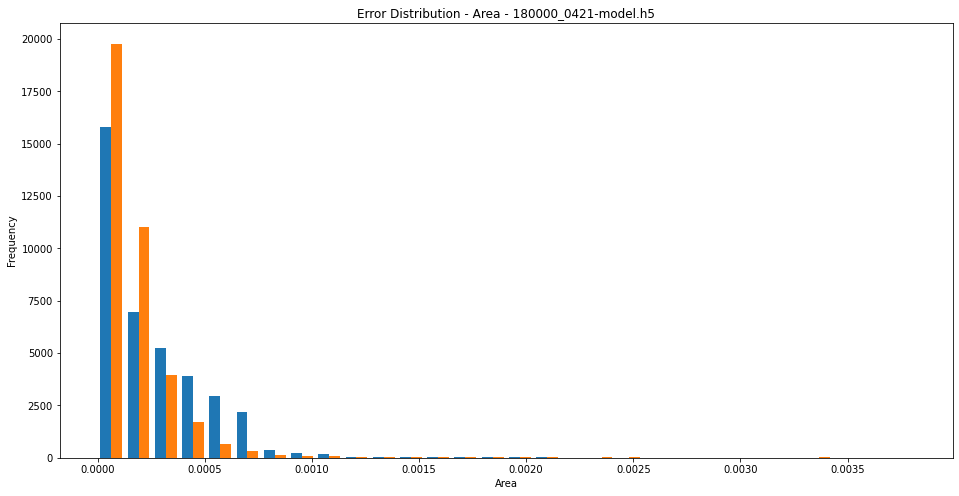

In [132]:
error_hist_and_save(area_error, 'Area', eight_model_file, DIAGRAM_FILE_PATH)

In [133]:
pct = 0.8
thresh = fixed_thresh(pct, area_error, len(train[seq_size:]))
thresh

array([0.00305096, 0.00305096, 0.00305096, ..., 0.00305096, 0.00305096,
       0.00305096])

In [134]:
anomaly_frame = anomaly_df(train, seq_size, area_error, thresh)
anomaly_frame.head()

left_angle  right_angle                    Date     error    thresh  \
80    0.341548     0.204577 2011-12-01 11:04:09.000  0.000625  0.003051   
81    0.341548     0.204854 2011-12-01 11:04:09.050  0.000628  0.003051   
82    0.341548     0.207906 2011-12-01 11:04:09.100  0.000629  0.003051   
83    0.341548     0.208322 2011-12-01 11:04:09.150  0.000630  0.003051   
84    0.337697     0.210264 2011-12-01 11:04:09.200  0.000630  0.003051   

    anomaly  
80    False  
81    False  
82    False  
83    False  
84    False

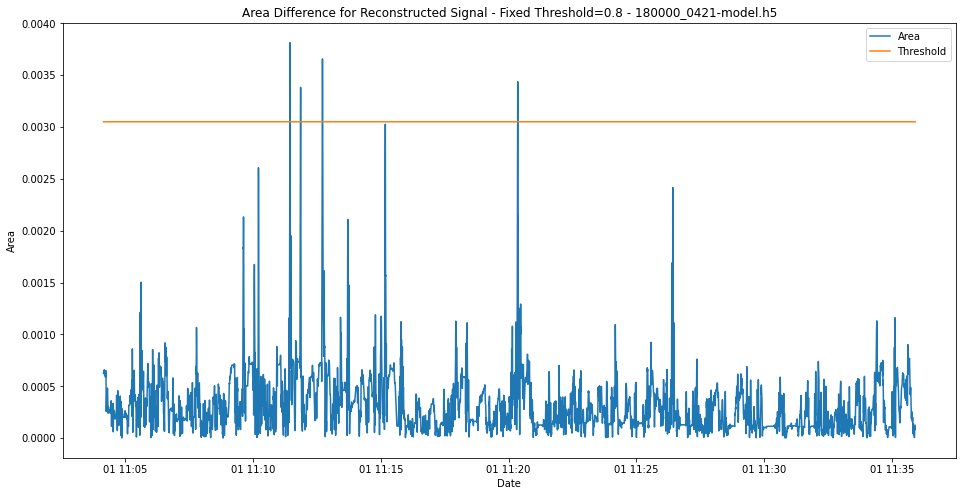

In [135]:
anomalies, _ = error_vs_thresh_plot_and_save(anomaly_frame, pct, 'Area', eight_model_file, DIAGRAM_FILE_PATH)

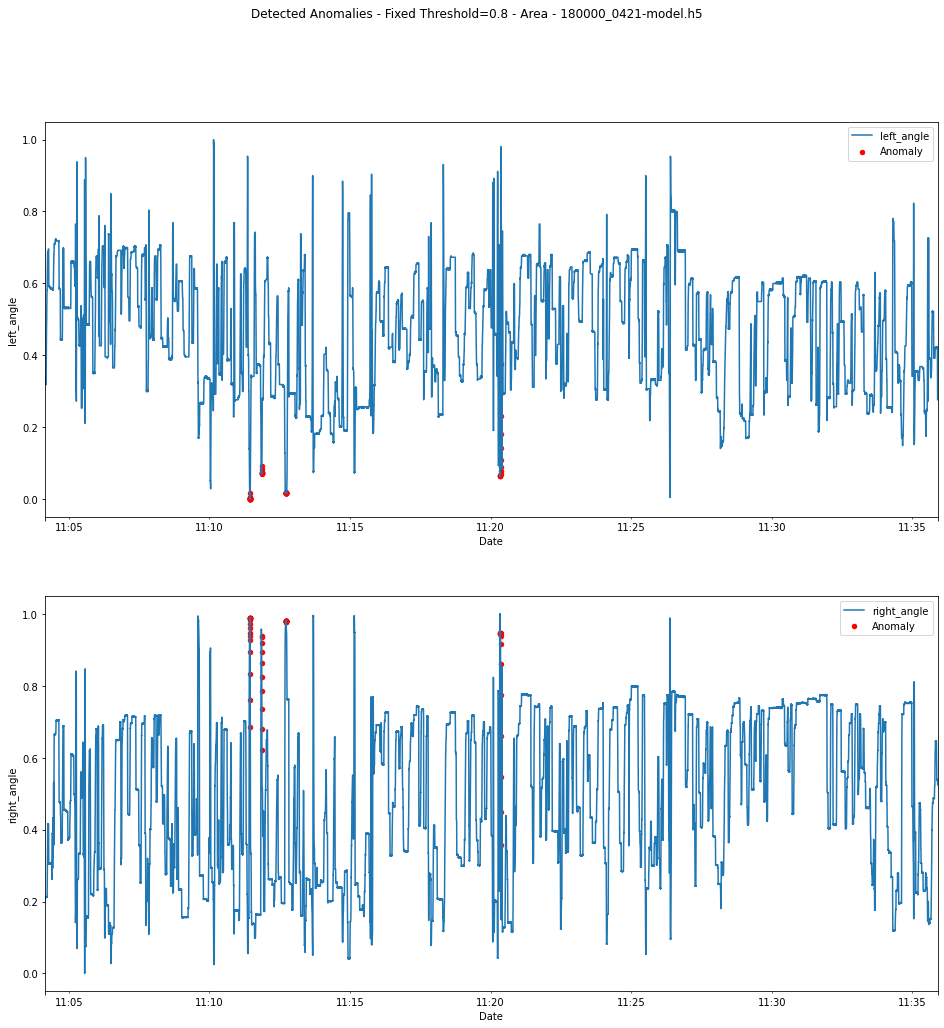

In [136]:
detect_anom_plot_and_save(no_feats, sensors, anomaly_frame, anomalies, pct, 'Area', eight_model_file, DIAGRAM_FILE_PATH)

## WINDOW SIZE = 120

In [137]:
file_version = 'ws120num2derFalse'
sensors = ['left_angle', 'right_angle'] #'back_angle', 
file_name = f'{file_version}-control.npy'
path = file_path + file_name
trainX = np.load(path)
print(f'Number of control training samples: {trainX.shape}')

Number of control training samples: (2382, 120, 2)


In [138]:
# Load just the patient data
file_patient = f'{file_version}-patient-shaved.npy'
path = file_path + file_patient
patientX = np.load(path)
print(f'Number of patient testing samples: {patientX.shape}')

Number of patient testing samples: (38067, 120, 2)


In [139]:
compress = 0.4
units_one = int(trainX.shape[1] * trainX.shape[2] * compress)
units_two = int(units_one * 0.5)
print(f"1st layer units: {units_one}, 2nd layer units: {units_two}")

1st layer units: 96, 2nd layer units: 48


In [140]:
onetwo_time_code = '181500_0421'
onetwo_model_file = f'{onetwo_time_code}-model.h5'
onetwo_model_file

'181500_0421-model.h5'

Checking for 181500_0421-model.h5

Double layer model built
Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_76 (LSTM)               (None, 120, 96)           38016     
_________________________________________________________________
dropout_38 (Dropout)         (None, 120, 96)           0         
_________________________________________________________________
lstm_77 (LSTM)               (None, 48)                27840     
_________________________________________________________________
repeat_vector_19 (RepeatVect (None, 120, 48)           0         
_________________________________________________________________
lstm_78 (LSTM)               (None, 120, 48)           18624     
_________________________________________________________________
lstm_79 (LSTM)               (None, 120, 96)           55680     
___________________________________________________________

<module 'matplotlib.pyplot' from '/Users/jamesmeyer/.pyenv/versions/fyp-env/lib/python3.9/site-packages/matplotlib/pyplot.py'>

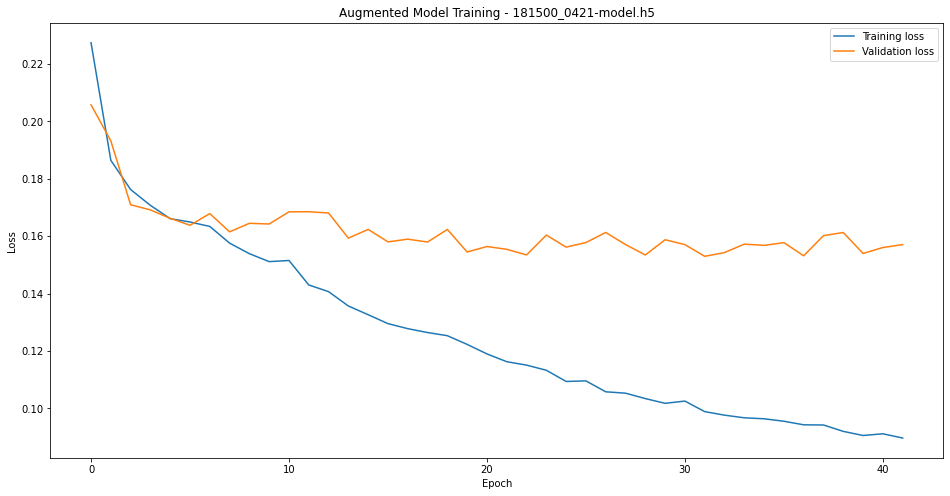

In [141]:
# Fit the model
callback = EarlyStopping(monitor='loss', patience=2, min_delta=1e-3)
WZ_onetwo = AutoEncoder(units_one, units_two, trainX, onetwo_model_file, callback)

# Show the history of loss
history_plot_and_save(WZ_onetwo.history, onetwo_model_file, DIAGRAM_FILE_PATH)

In [142]:
patientPredict = WZ_onetwo.model.predict(patientX)

In [143]:
no_feats = trainX.shape[2]
seq_size = trainX.shape[1]
example = 10

<module 'matplotlib.pyplot' from '/Users/jamesmeyer/.pyenv/versions/fyp-env/lib/python3.9/site-packages/matplotlib/pyplot.py'>

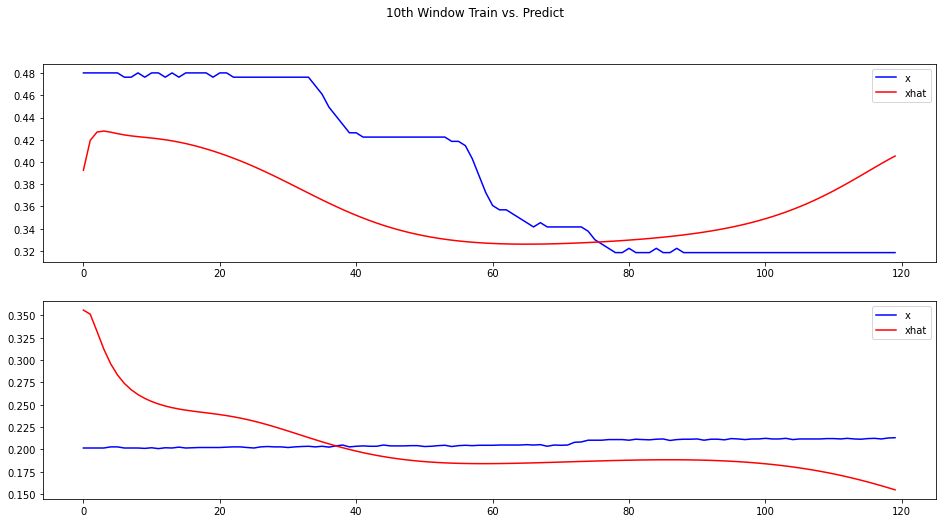

In [144]:
example_plot(example, no_feats, seq_size, patientX, patientPredict)

In [145]:
area_error = error_computation(patientX, patientPredict, 'Area')
area_error.shape

(38067, 2)

<module 'matplotlib.pyplot' from '/Users/jamesmeyer/.pyenv/versions/fyp-env/lib/python3.9/site-packages/matplotlib/pyplot.py'>

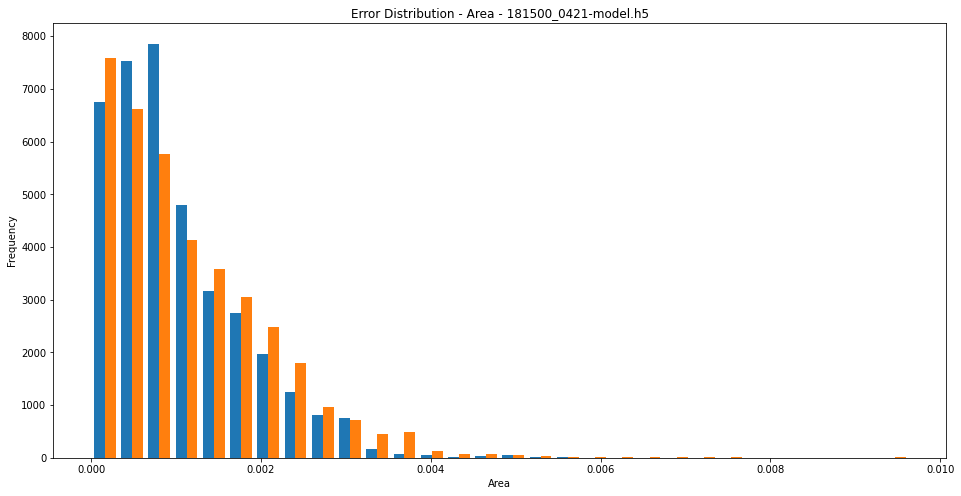

In [146]:
error_hist_and_save(area_error, 'Area', onetwo_model_file, DIAGRAM_FILE_PATH)

In [147]:
pct = 0.8
thresh = fixed_thresh(pct, area_error, len(train[seq_size:]))
thresh

array([0.00769819, 0.00769819, 0.00769819, ..., 0.00769819, 0.00769819,
       0.00769819])

In [148]:
anomaly_frame = anomaly_df(train, seq_size, area_error, thresh)
anomaly_frame.head()

left_angle  right_angle                    Date     error    thresh  \
120    0.318444     0.212067 2011-12-01 11:04:11.000  0.000708  0.007698   
121    0.318444     0.211650 2011-12-01 11:04:11.050  0.000691  0.007698   
122    0.318444     0.212344 2011-12-01 11:04:11.100  0.000677  0.007698   
123    0.318444     0.211650 2011-12-01 11:04:11.150  0.000667  0.007698   
124    0.318444     0.211373 2011-12-01 11:04:11.200  0.000661  0.007698   

     anomaly  
120    False  
121    False  
122    False  
123    False  
124    False

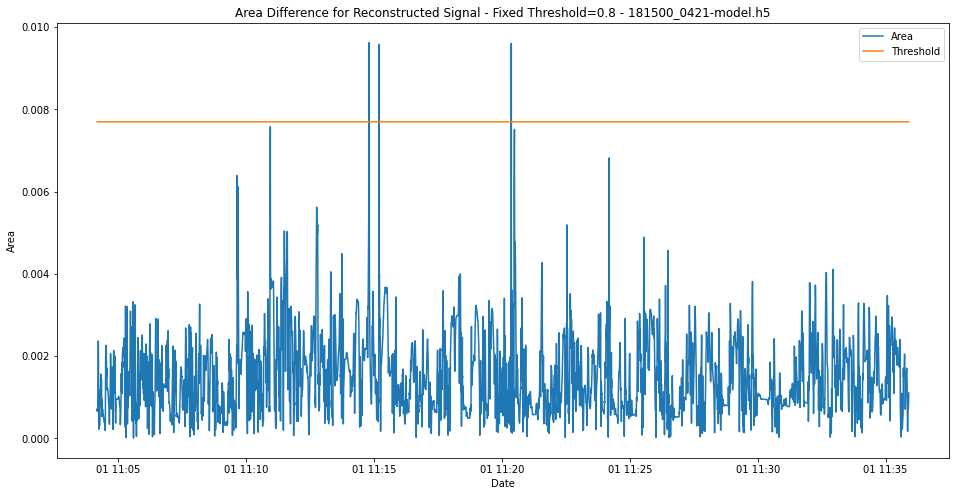

In [149]:
anomalies, _ = error_vs_thresh_plot_and_save(anomaly_frame, pct, 'Area', onetwo_model_file, DIAGRAM_FILE_PATH)

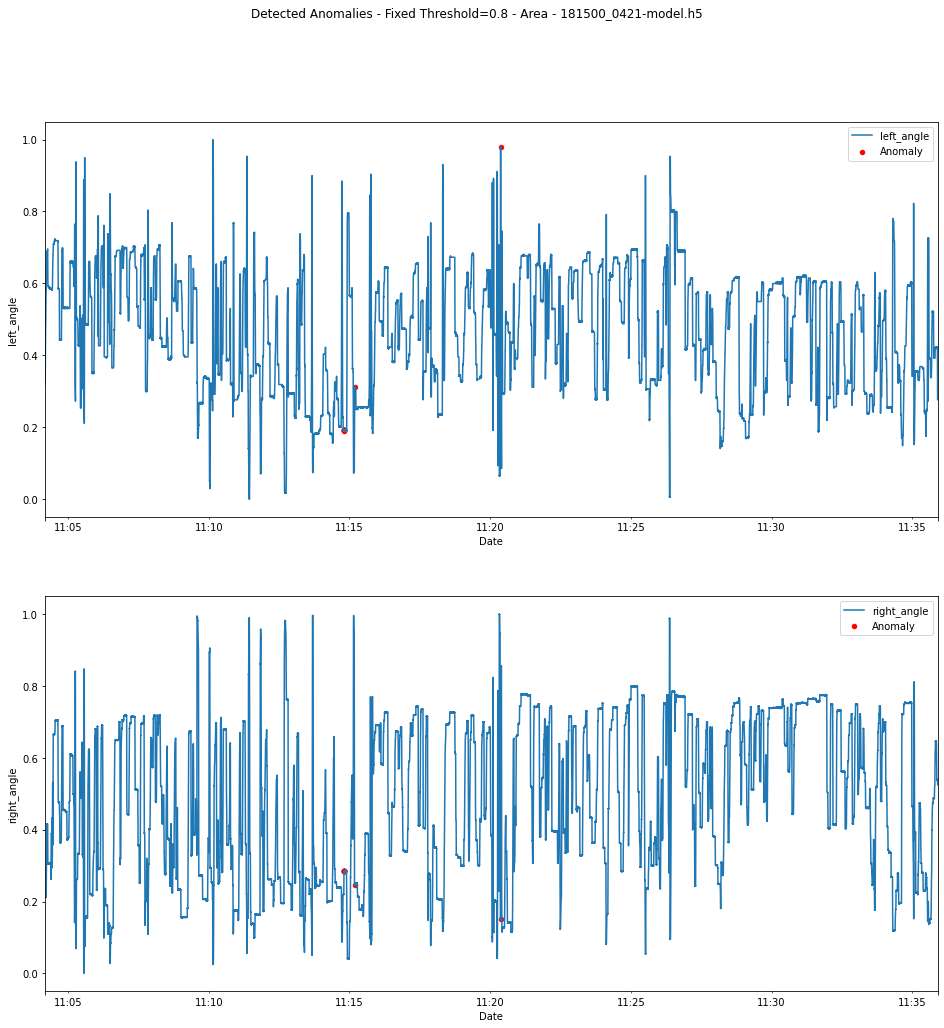

In [150]:
detect_anom_plot_and_save(no_feats, sensors, anomaly_frame, anomalies, pct, 'Area', onetwo_model_file, DIAGRAM_FILE_PATH)

In [151]:
file_version = 'ws100num2derFalse'
sensors = ['left_angle', 'right_angle'] #'back_angle', 
file_name = f'{file_version}-control.npy'
path = file_path + file_name
trainX = np.load(path)
print(f'Number of control training samples: {trainX.shape}')

Number of control training samples: (3868, 100, 2)


In [152]:
# Load just the patient data
file_patient = f'{file_version}-patient-shaved.npy'
path = file_path + file_patient
patientX = np.load(path)
print(f'Number of patient testing samples: {patientX.shape}')

Number of patient testing samples: (38087, 100, 2)


In [153]:
compress = 0.4
units_one = int(trainX.shape[1] * trainX.shape[2] * compress)
units_two = int(units_one * 0.5)
print(f"1st layer units: {units_one}, 2nd layer units: {units_two}")

1st layer units: 80, 2nd layer units: 40


In [158]:
hund_time_code = '110000_0420'
hund_model_file = f'{hund_time_code}-model.h5'
hund_model_file

'110000_0420-model.h5'

In [174]:
# Fit the model
callback = EarlyStopping(monitor='loss', patience=2, min_delta=1e-3)
WZ_hund = AutoEncoder(units_one, units_two, trainX, hund_model_file, callback, DIAGRAM_FILE_PATH)

# Show the history of loss
# history_plot_and_save(WZ_hund.history, hund_model_file, DIAGRAM_FILE_PATH)

Checking for 110000_0420-model.h5

Model loaded from: 110000_0420-model.h5
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 100, 80)           26560     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100, 80)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 40)                19360     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 100, 40)           0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 100, 40)           12960     
_________________________________________________________________
lstm_7 (LSTM)                (None, 100, 80)           38720     
_____________________________________________

In [160]:
patientPredict = WZ_hund.model.predict(patientX)

In [161]:
no_feats = trainX.shape[2]
seq_size = trainX.shape[1]
example = 10

<module 'matplotlib.pyplot' from '/Users/jamesmeyer/.pyenv/versions/fyp-env/lib/python3.9/site-packages/matplotlib/pyplot.py'>

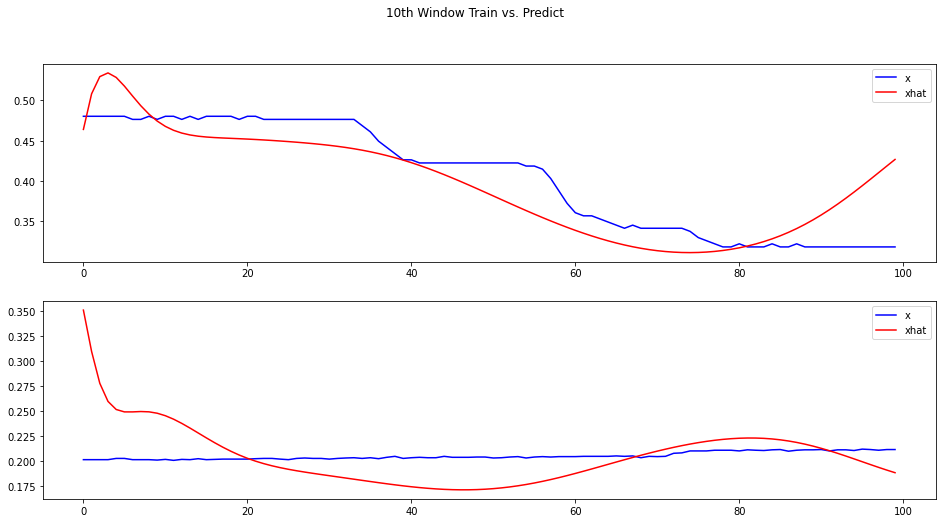

In [162]:
example_plot(example, no_feats, seq_size, patientX, patientPredict)

In [163]:
area_error = error_computation(patientX, patientPredict, 'Area')
area_error.shape

(38087, 2)

Saved as: /Users/jamesmeyer/University of Bath/Patient Simulator FYP - General/diagrams/error-hist-Area-110000_0420-model.h5-2.png


<module 'matplotlib.pyplot' from '/Users/jamesmeyer/.pyenv/versions/fyp-env/lib/python3.9/site-packages/matplotlib/pyplot.py'>

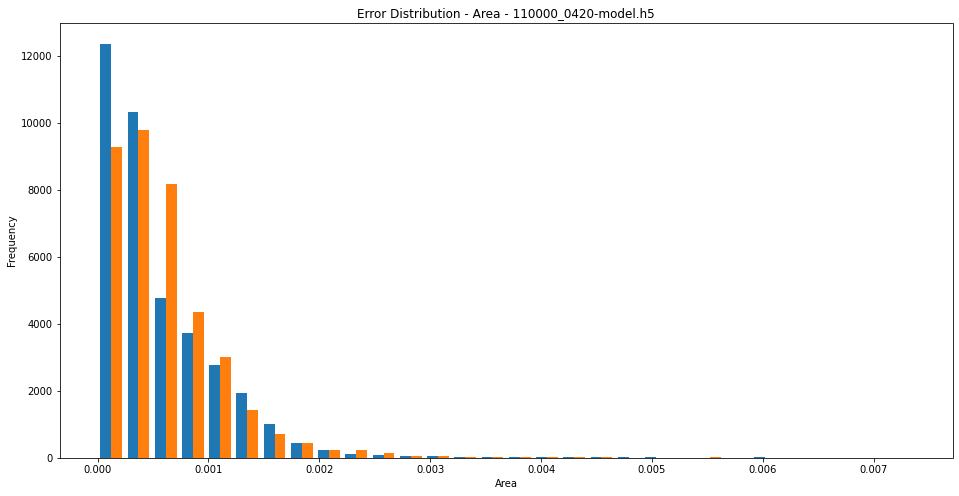

In [170]:
error_hist_and_save(area_error, 'Area', hund_model_file, DIAGRAM_FILE_PATH)

In [165]:
pct = 0.8
thresh = fixed_thresh(pct, area_error, len(train[seq_size:]))
thresh

array([0.00589483, 0.00589483, 0.00589483, ..., 0.00589483, 0.00589483,
       0.00589483])

In [166]:
anomaly_frame = anomaly_df(train, seq_size, area_error, thresh)
anomaly_frame.head()

left_angle  right_angle                    Date     error    thresh  \
100    0.318444     0.211650 2011-12-01 11:04:10.000  0.000211  0.005895   
101    0.318444     0.210264 2011-12-01 11:04:10.050  0.000198  0.005895   
102    0.318444     0.211373 2011-12-01 11:04:10.100  0.000186  0.005895   
103    0.318444     0.211373 2011-12-01 11:04:10.150  0.000174  0.005895   
104    0.318444     0.210680 2011-12-01 11:04:10.200  0.000164  0.005895   

     anomaly  
100    False  
101    False  
102    False  
103    False  
104    False

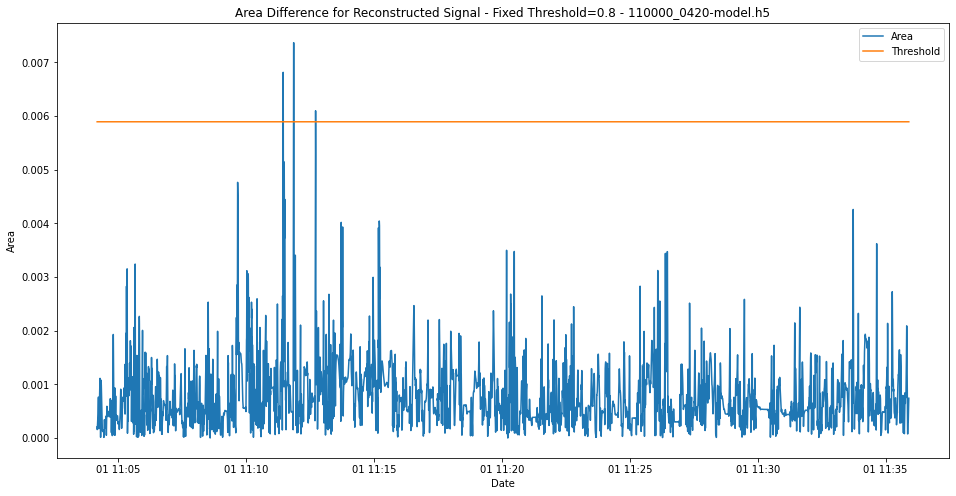

In [167]:
anomalies, _ = error_vs_thresh_plot_and_save(anomaly_frame, pct, 'Area', hund_model_file, DIAGRAM_FILE_PATH)

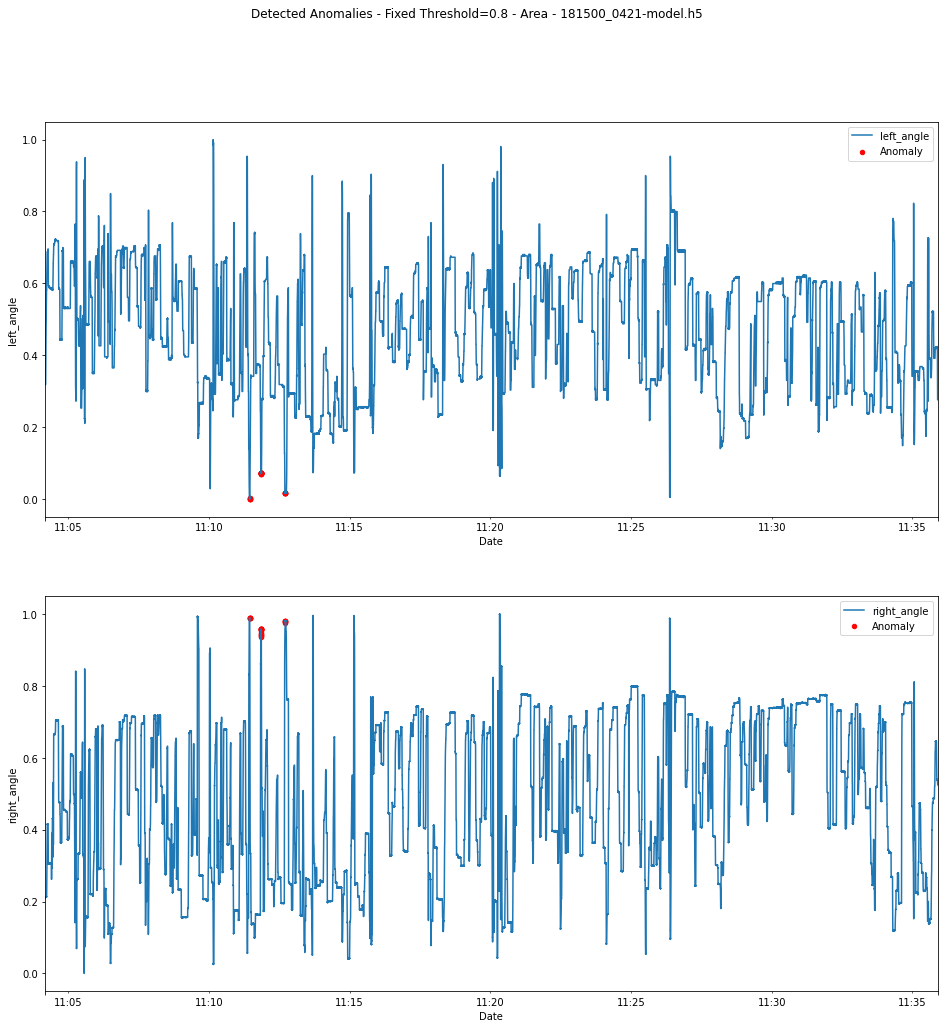

In [168]:
detect_anom_plot_and_save(no_feats, sensors, anomaly_frame, anomalies, pct, 'Area', onetwo_model_file, DIAGRAM_FILE_PATH)

## Closing points
- The most sensitive to abrupt spikes seemed to be 20 & 80
- 40, 60, 100 & 120 seem to somewhat sensitive to the spikes but not consistently
- Is 20 the best because it implies the quickest respone time as well/smallest network size to train?